In [1]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np.random.seed(1)
tf.random.set_seed(2)

NGRAMS = 2
FEATURE_LEN = 128
EPOCHS = 15
SAMPLES = 50000

In [2]:
adf = pd.read_csv('../train-test/data/top-1m.csv.zip', header=None, nrows=SAMPLES)
adf.columns = ['rank', 'domain']
adf = adf[['domain']]
adf

,domain
0,google.com
1,youtube.com
2,facebook.com
3,baidu.com
4,wikipedia.org
...,...
49995,reblop.com
49996,tiching.com
49997,akdeniz.edu.tr
49998,labporn.com


In [3]:
adf['malware_cat'] = 0
adf

,domain,malware_cat
0,google.com,0
1,youtube.com,0
2,facebook.com,0
3,baidu.com,0
4,wikipedia.org,0
...,...,...
49995,reblop.com,0
49996,tiching.com,0
49997,akdeniz.edu.tr,0
49998,labporn.com,0


In [4]:
# Malware Domain
df = pd.read_csv('../train-test/data/malware_2017.csv.bz2', usecols=['domain'])
df['malware_cat'] = 1
df

,domain,malware_cat
0,amazon.co.uk.security-check.ga,1
1,autosegurancabrasil.com,1
2,dadossolicitado-antendimento.sad879.mobi,1
3,hitnrun.com.my,1
4,maruthorvattomsrianjaneyatemple.org,1
...,...,...
15233,windowspeed.top,1
15234,wvw2-itunes.com,1
15235,yoursmartservice.ru,1
15236,yourtableteshop.eu,1


In [5]:
sdf = pd.concat([adf, df])
sdf

,domain,malware_cat
0,google.com,0
1,youtube.com,0
2,facebook.com,0
3,baidu.com,0
4,wikipedia.org,0
...,...,...
15233,windowspeed.top,1
15234,wvw2-itunes.com,1
15235,yoursmartservice.ru,1
15236,yourtableteshop.eu,1


## Preprocessing the input data

In [6]:
# build n-gram list
#vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=3, ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
vect = CountVectorizer(analyzer='char', ngram_range=(NGRAMS, NGRAMS), lowercase=False) 
a = vect.fit_transform(sdf.domain)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = [w[1] for w in words]
num_words = len(words_list)
print("num_words = %d" % num_words)


def find_ngrams(text, n):
    a = zip(*[text[i:] for i in range(n)])
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.domain.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

num_words = 1448


In [7]:
print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = sdf.malware_cat

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
#X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Max feature len = 209, Avg. feature len = 13


In [8]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 10000, 1: 3048}

In [9]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 40000, 1: 12190}

## Train a LSTM model

In [10]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = FEATURE_LEN # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


52190 train sequences
13048 test sequences
Pad sequences (samples x time)


Using TensorFlow backend.


X_train shape: (52190, 128)
X_test shape: (13048, 128)


In [11]:
from keras.models import load_model
vocab_path = 'models/malware_cat_vocab_2017.csv'
model_path = 'models/malware_cat_lstm_2017.h5'
vdf = pd.read_csv(vocab_path)
vocab = vdf.vocab.tolist()
print(len(vocab))
model = load_model(model_path)

## Confusion Matrix

In [18]:
y_pred = model.predict_classes(X_test, verbose=1)
y_probs = model.predict_proba(X_test, verbose=1) # to predict probability
target_names = list(sdf.malware_cat.astype('category').cat.categories)

13048/13048 [==============================] - 27s 2ms/step


In [19]:
target_names = [str(t) for t in target_names]
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))    

              precision    recall  f1-score   support

           0       0.86      0.95      0.91     10000
           1       0.77      0.51      0.61      3048

    accuracy                           0.85     13048
   macro avg       0.82      0.73      0.76     13048
weighted avg       0.84      0.85      0.84     13048

[[9545  455]
 [1503 1545]]


## Train a Random Forest Model

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100, 
                                  bootstrap = True,
                                  max_features = 'sqrt')
# Fit on training data
rf_model.fit(X_train, y_train)

In [33]:
# Actual class predictions
rf_y_pred = rf_model.predict(X_test)
# Probabilities for each class
rf_y_probs = rf_model.predict_proba(X_test)[:, 1]

## Confusion Matrix

In [34]:
p = rf_y_probs
target_names = list(sdf.malware_cat.astype('category').cat.categories)

In [35]:
target_names = [str(t) for t in target_names]
print(classification_report(y_test, rf_y_pred, target_names=target_names))
print(confusion_matrix(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90     10000
           1       0.79      0.41      0.54      3048

    accuracy                           0.84     13048
   macro avg       0.81      0.69      0.72     13048
weighted avg       0.83      0.84      0.82     13048

[[9658  342]
 [1790 1258]]


## Train an SVM Model

In [25]:
from sklearn import svm

svc_model = svm.SVC(probability=True)
# Fit on training data
svc_model.fit(X_train, y_train)

In [26]:
# Actual class predictions
svc_y_pred = svc_model.predict(X_test)
# Probabilities for each class
svc_y_probs = svc_model.predict_proba(X_test)[:, 1]

## Confusion Matrix

In [27]:
p = svc_y_probs
target_names = list(sdf.malware_cat.astype('category').cat.categories)

In [28]:
target_names = [str(t) for t in target_names]
print(classification_report(y_test, svc_y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred))    

              precision    recall  f1-score   support

           0       0.83      0.97      0.90     10000
           1       0.79      0.34      0.48      3048

    accuracy                           0.83     13048
   macro avg       0.81      0.66      0.69     13048
weighted avg       0.82      0.83      0.80     13048

[[9545  455]
 [1503 1545]]


In [36]:
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score

lstm_fpr, lstm_tpr, lstm_thresholds = roc_curve ( y_test , y_probs)
rf_fpr, rf_tpr, rf_thresholds = roc_curve ( y_test , rf_y_probs)
svc_fpr, svc_tpr, svc_thresholds = roc_curve ( y_test , svc_y_probs)

In [37]:
lstm_auc = roc_auc_score(y_test, y_probs)
rf_auc = roc_auc_score(y_test, rf_y_probs)
svc_auc = roc_auc_score(y_test, svc_y_probs)
lstm_auc, rf_auc, svc_auc

(0.850546965223097, 0.8309320538057743, 0.7365861712598425)

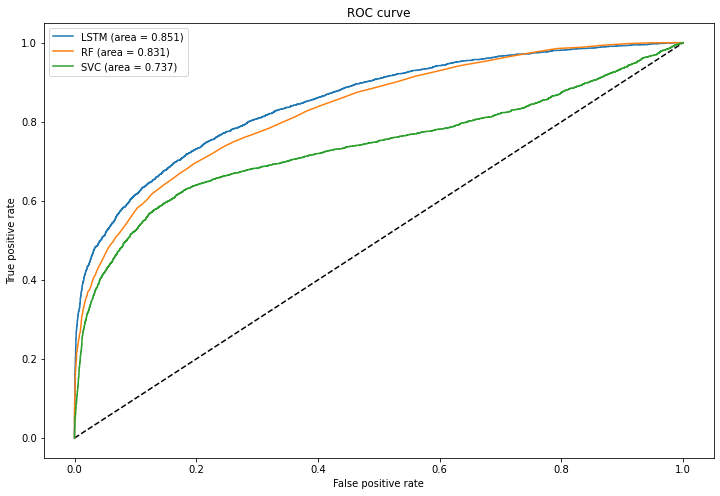

In [38]:
fig = plt.figure(1, figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lstm_fpr, lstm_tpr, label='LSTM (area = {:.3f})'.format(lstm_auc))
plt.plot(rf_fpr, rf_tpr, label='RF (area = {:.3f})'.format(rf_auc))
plt.plot(svc_fpr, svc_tpr, label='SVC (area = {:.3f})'.format(svc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [39]:
fig.savefig('./roc-malware-lstm-rf-svc.eps', format='eps', dpi=300);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


## Save model

In [ ]:
model.save('./models/malware_cat_lstm_2017.h5')

In [ ]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('./models/malware_cat_vocab_2017.csv', index=False, encoding='utf-8')

In [ ]:
import pickle

pickle.dump(rf_model, open('./models/malware_cat_2017_rf.pickle', 'wb'))
pickle.dump(svc_model, open('./models/malware_cat_2017_svm.pickle', 'wb'))